#### detection -> crop predicted images

참고) https://docs.ultralytics.com/reference/engine/results/#ultralytics.engine.results.BaseTensor.numpy

#### color extraction
* https://github.com/CairX/extract-colors-py?tab=readme-ov-file#id14
* https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_illustrations.html#sphx-glr-auto-examples-transforms-plot-transforms-illustrations-py
* https://webcolors.readthedocs.io/en/latest/contents.html
* https://matplotlib.org/stable/users/explain/colors/colors.html
* https://xkcd.com/color/rgb/


In [3]:
import os
import extcolors
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import matplotlib.colors as mcolors
import pandas as pd

from ultralytics import YOLO

import torch
from torchvision.transforms import v2 # pytorch

In [17]:
# def ################################################################################

# detection과 object부분 크롭
def crop_imgs(img_path, custom_model):
    model = YOLO(custom_model)  # load a pretrained YOLOv8n detection model

    # model.train(data='coco128.yaml', epochs=3)  # train the model
    model.predict(img_path, save_crop=True)  # predict on an image 
    # 추가 파라미터: save_txt=True, show=True 사용 가능

    # # Extract bounding boxes, classes, names, and confidences
    # boxes = results[0].boxes.xyxy.tolist()
    # classes = results[0].boxes.cls.tolist()
    # names = results[0].names
    # confidences = results[0].boxes.conf.tolist()

    # # Iterate through the results
    # for box, cls, conf in zip(boxes, classes, confidences):
    #     x1, y1, x2, y2 = box
    #     confidence = conf
    #     detected_class = cls
    #     name = names[int(cls)]


# XKCD COLORS info를 df로 생성
def colors_df():
  global df
  df = pd.DataFrame(columns=['name','red','green','blue'])
  for color_name, color_hex in mcolors.XKCD_COLORS.items():
      r, g, b = mcolors.to_rgb(color_hex)
      df = pd.concat([df, pd.DataFrame({'name':[color_name], 'red':[r], 'green':[g], 'blue':[b]})], ignore_index= True)
  return df

# 가까운 색상명
def closest_color(rgb):
  differences = {}
  for color_name, color_hex in mcolors.XKCD_COLORS.items(): # mcolors.CSS4_COLORS mcolors.XKCD_COLORS
    r, g, b = mcolors.to_rgb(color_hex)

    differences[sum([(r*255-rgb[0])**2,
                    (g*255-rgb[1])**2,
                    (b*255-rgb[2])**2])] = color_name
    
  return differences[min(differences.keys())]



# 이미지 색상명 추출
def find_colorname(item, croppedfolder):
  top_img = os.listdir(croppedfolder + item)[0]
  top_img_path = croppedfolder + item + '/' + top_img

  org_img = Image.open(top_img_path)

  # 원본 이미지 사이즈 구하기
  org_img_size = v2.functional.get_size(org_img)

  # 가로, 세로 중 짧은 쪽의 80% 길이로 만들기
  size_80 = min(org_img_size[0], org_img_size[1]) * 0.8
  centercrop = v2.CenterCrop(size_80)
  img_size80 = centercrop(org_img)

  # plt.imshow(img_size80)

  # 색상 추출
  colors, pixel_count = extcolors.extract_from_image(img_size80)

  # output
  clothes_color = closest_color(colors[0][0])

  # check the colors
  # rgb_list = [colors[0][0]] # 가장 많은 컬러
  # one_px = np.array(rgb_list)[np.newaxis, :, :]

  # plt.imshow(np.array(one_px))
  # plt.axis('off')
  # plt.show()
  return clothes_color


# 파일명 없으면 생성
def makedirs(path):
    if not os.path.exists(path):
        os.makedirs(path)


In [ ]:
# run ###############################################

# 색상, 옷 카테고리 결과 담을 df
result = pd.DataFrame(columns=['img_path','top_category','top_color','bottom_category','bottom_color'])

# source info
image_folder = '.\\images\\'
custom_model = '..\\object_detection\\runs\\detect\\datav5result\\weights\\best.pt'

for img in os.listdir(image_folder):
    image_source = image_folder + img

    try:
        # object에 맞게 이미지 크롭
        crop_imgs(image_source, custom_model)

        # 크롭된 이미지의 위치
        cropped_folder = r'./runs/detect/predict/crops/'
        for item in os.listdir(cropped_folder): # 해당 폴더 내 모든 파일 및 폴더 추출
            # item: 옷 카테고리명
            color = find_colorname(item, cropped_folder)
            if item in ['shirt','sweater','mtm','hoodies','longsleeve','shortsleeve','jacket','blazer','padding','zipup','cardigan','coat']:
                top = {'item':item, 'color':color}
            else: # skirt, denim pants, cotton pants, trainingpants, slacks, short pants
                bottom = {'item':item, 'color':color}

        # result df에 추가
        result = pd.concat([result, pd.DataFrame({'img_path':[image_source],'top_category':[top.get('item')],
                                                'top_color':[top.get('color')],'bottom_category':[bottom.get('item')],
                                                'bottom_color':[bottom.get('color')]})], ignore_index= True)
            
        # cropped_folder 삭제
        import shutil
        shutil.rmtree(r'./runs/')
    except:
        continue



In [5]:
result.to_csv('./result.csv',index=False, encoding='utf-8')

#### colors 다시 분류

In [77]:
color_df = colors_df()

green = ['green','apple',
'algae',
'asparagus',
'avocado',
'poo',
'poop',
'bile',
'booger',
'lime',
'olive',
'khaki']

black = ['black','charcoal','dark']

blue = ['aqua',
'blue',
'marine',
'azul',
'azure',
'blueberry',
'bluish',
'cyan',
'teal',
'cobalt',
'cornflower',
'navy']

grey = ['grey','steel','silver','cement','greyish','gunmetal']

white = ['white']

orange = ['orange']

red = ['red','blood','berry','rose']

purple = ['amethyst','purple', 'barney', 
'violet',
'lavender',
'bruise',
'lilac',
'eggplant','indigo','iris']

pink = ['pink',
'blush',
'magenta',
'bubblegum']

brown = [
    'brown',
'bronze',
'brownish',
'brick',
'burgundy',
'sienna',
'umber',
'chocolate',
'chestnut',
'cinnamon',
'clay',
'coffee',
'copper'
]

yellow = [
    'yellow',
'banana',
'buff',
'butter',
'cream',
'creme',
'custard',
'dandelion'
]

In [78]:
color_df['main_color'] = ''

for i, c in enumerate(color_df['name']):

    color = c.replace('xkcd:','').split(' ')[-1]

    if color in green:
        color_df['main_color'][i] = 'green'
    elif color in black:
        color_df['main_color'][i] = 'black'
    elif color in blue:
        color_df['main_color'][i] = 'blue'
    elif color in grey:
        color_df['main_color'][i] = 'grey'
    elif color in white:
        color_df['main_color'][i] = 'white'
    elif color in orange:
        color_df['main_color'][i] = 'orange'
    elif color in red:
        color_df['main_color'][i] = 'red'
    elif color in purple:
        color_df['main_color'][i] = 'purple'
    elif color in pink:
        color_df['main_color'][i] = 'pink'
    elif color in brown:
        color_df['main_color'][i] = 'brown'
    elif color in yellow:
        color_df['main_color'][i] = 'yellow'
    else:
        color_df['main_color'][i] = 'others'

color_df

C:\Users\Andlab\AppData\Local\Temp\ipykernel_7824\659598059.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  color_df['main_color'][i] = 'blue'
C:\Users\Andlab\AppData\Local\Temp\ipykernel_7824\659598059.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  color_df['main_color'][i] = 'green'
C:\Users\Andlab\AppData\Local\Temp\ipykernel_7824\659598059.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  color_df['main_color'][i] = 'o

name       red     green      blue main_color
0          xkcd:cloudy blue  0.674510  0.760784  0.850980       blue
1    xkcd:dark pastel green  0.337255  0.682353  0.341176      green
2                 xkcd:dust  0.698039  0.600000  0.431373     others
3        xkcd:electric lime  0.658824  1.000000  0.015686      green
4          xkcd:fresh green  0.411765  0.847059  0.309804      green
..                      ...       ...       ...       ...        ...
944              xkcd:brown  0.396078  0.215686  0.000000      brown
945               xkcd:pink  1.000000  0.505882  0.752941       pink
946               xkcd:blue  0.011765  0.262745  0.874510       blue
947              xkcd:green  0.082353  0.690196  0.101961      green
948             xkcd:purple  0.494118  0.117647  0.611765     purple

[949 rows x 5 columns]

In [79]:
color_df.to_csv('./maincolors.csv',encoding='utf-8',index=False)

In [80]:
color_df['name'][color_df['main_color'] == 'others']

2                     xkcd:dust
8                      xkcd:tea
10           xkcd:yellowish tan
15     xkcd:macaroni and cheese
16             xkcd:pinkish tan
                 ...           
918                 xkcd:salmon
920                 xkcd:maroon
923                  xkcd:mauve
927                    xkcd:tan
930              xkcd:turquoise
Name: name, Length: 246, dtype: object

In [81]:
maincolors= pd.read_csv('./maincolors.csv').drop(columns=['red','blue','green'])
result = pd.read_csv('./result.csv')

result = pd.merge(result, maincolors, how='left', left_on='top_color', right_on='name').drop(columns='name').rename(columns={'main_color':'top_color_cluster'})
result = pd.merge(result, maincolors, how='left', left_on='bottom_color', right_on='name').drop(columns='name').rename(columns={'main_color':'bottom_color_cluster'})

In [82]:
result.to_csv('./result_maincolors.csv',encoding='utf-8',index=False)

#### color clustering: dbscan (사용안함)

In [34]:
colors_df()

# df 행 셔플
df = df.sample(frac=1)

In [88]:
from sklearn.cluster import DBSCAN

model = DBSCAN(eps=0.1
               , min_samples=4)

data = df.drop(columns='name')

model.fit(data)

df['cluster'] = model.fit_predict(data)

In [89]:
len(df['cluster'].unique())

40

In [90]:
df['cluster'].value_counts()

 0     235
-1     166
 2     136
 5      47
 1      45
 14     28
 13     24
 7      23
 15     19
 3      15
 4      15
 12     14
 6      14
 11     13
 16     12
 20     11
 22     10
 23      9
 25      8
 27      8
 17      8
 21      7
 24      6
 38      5
 34      5
 31      5
 18      5
 28      5
 36      5
 8       5
 9       5
 37      4
 26      4
 32      4
 29      4
 19      4
 35      4
 33      4
 10      4
 30      4
Name: cluster, dtype: int64

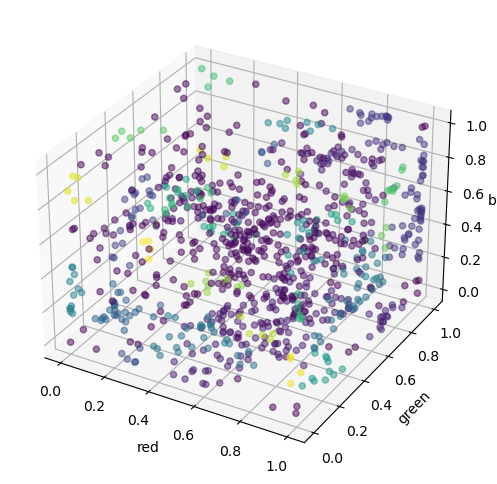

In [91]:
from mpl_toolkits.mplot3d import Axes3D
# scatter plot
fig = plt.figure( figsize=(6,6))
ax = fig.add_subplot(projection='3d')
ax.scatter(df['red'],df['green'],df['blue'],c=df['cluster'], alpha=0.5)
ax.set_xlabel('red')
ax.set_ylabel('green')
ax.set_zlabel('blue')
plt.show()

In [92]:
# eps=0.1, min_samples=2
# eps=0.1, min_samples=5
# eps=0.1, min_samples=10 
# eps=0.09, min_samples=10
# eps=0.09, min_samples=3 (this)
df.to_csv('./cluster.csv',encoding='utf-8',index=False)

In [93]:
cluster= pd.read_csv('./cluster.csv').drop(columns=['red','blue','green'])
result = pd.read_csv('./result.csv')

result = pd.merge(result, cluster, how='left', left_on='top_color', right_on='name').drop(columns='name').rename(columns={'cluster':'top_color_cluster'})
result = pd.merge(result, cluster, how='left', left_on='bottom_color', right_on='name').drop(columns='name').rename(columns={'cluster':'bottom_color_cluster'})

In [98]:
result.to_csv('./result_colorclustering.csv',encoding='utf-8',index=False)

#### Show the results

In [83]:
result = pd.read_csv('./result_maincolors.csv')
result

img_path top_category           top_color bottom_category  \
0    .\images\31514243.jpg      hoodies          xkcd:black      shortpants   
1    .\images\31596170.jpg      sweater      xkcd:dark grey      shortpants   
2    .\images\31669490.jpg       blazer          xkcd:black          slacks   
3    .\images\31747193.jpg      sweater         xkcd:cement      denimpants   
4    .\images\31832905.jpg      sweater     xkcd:grey brown   trainingpants   
..                     ...          ...                 ...             ...   
450  .\images\52091846.jpg      sweater   xkcd:pinkish grey      denimpants   
451  .\images\52114670.jpg          mtm  xkcd:greyish brown          slacks   
452  .\images\52192602.jpg      sweater   xkcd:reddish grey     cottonpants   
453  .\images\52192687.jpg      sweater      xkcd:warm grey      denimpants   
454  .\images\52818654.jpg      sweater     xkcd:brown grey      denimpants   

             bottom_color top_color_cluster bottom_color_cluster  
0              xkcd:black             black                black  
1               xkcd:dark              grey                black  
2    xkcd:battleship grey             black                 grey  
3              xkcd:slate              grey               others  
4    xkcd:very dark brown             brown                brown  
..                    ...               ...                  ...  
450         xkcd:gunmetal              grey                 grey  
451        xkcd:dark grey             brown                 grey  
452       xkcd:light grey              grey                 grey  
453     xkcd:almost black              grey                black  
454     xkcd:almost black              grey                black  

[455 rows x 7 columns]

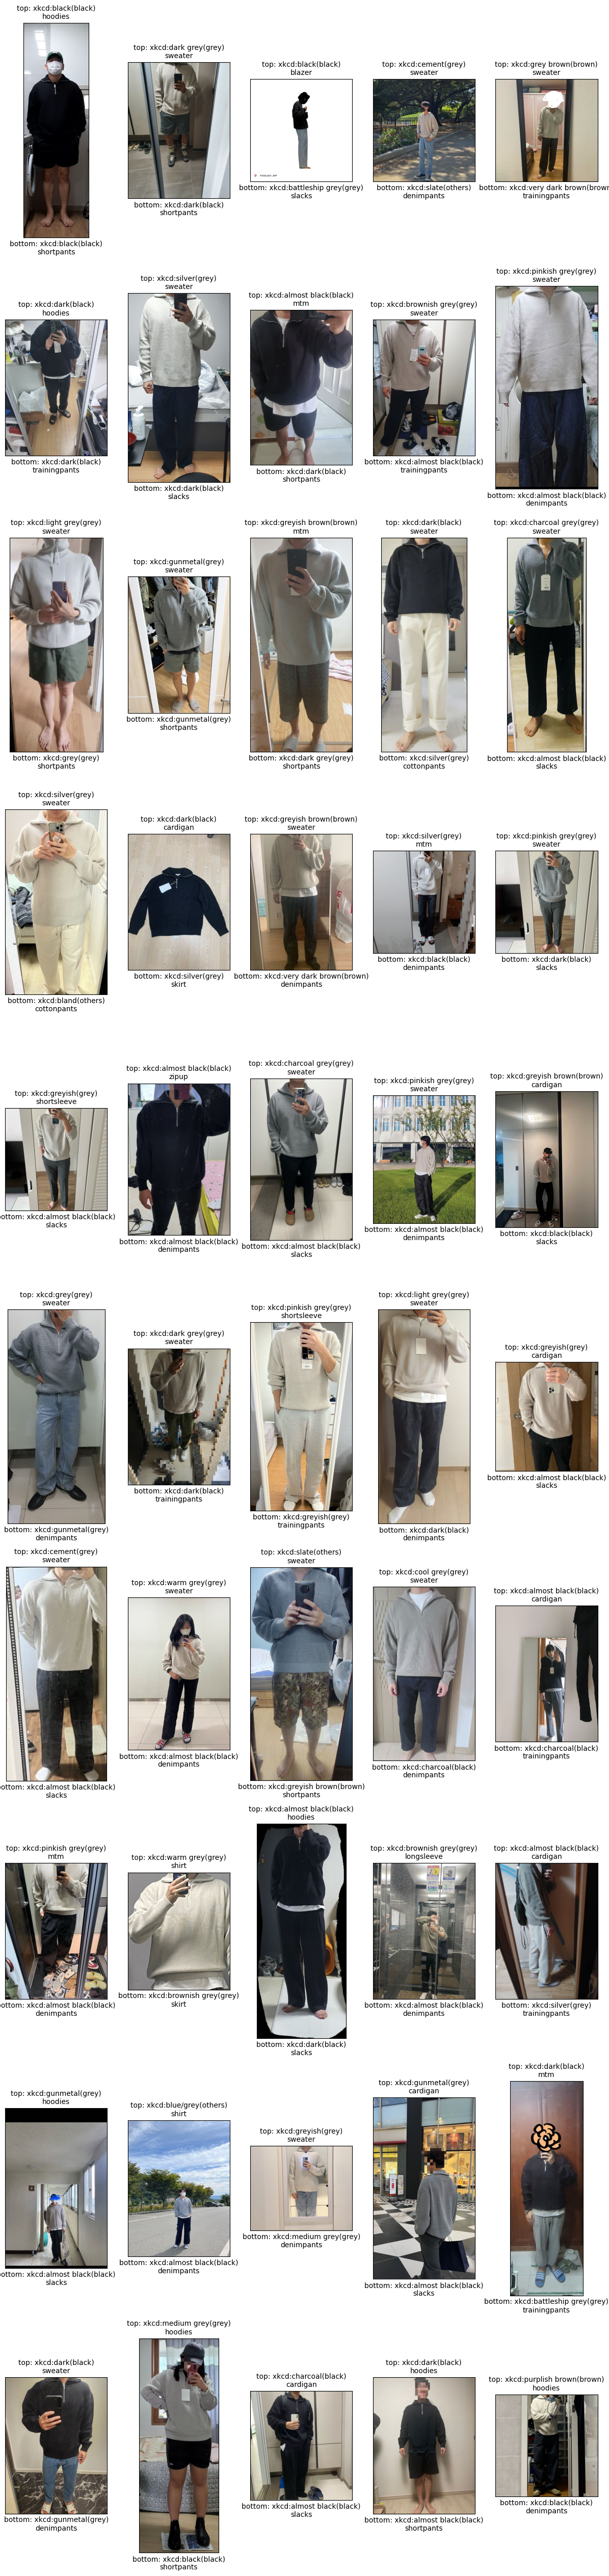

In [84]:
from PIL import Image
import matplotlib.pyplot as plt

# // %matplotlib inline

plt.rcParams['figure.figsize'] = (15.0, 130.0)



# struct is  [10, 5]
rows = 20
columns = 5

for i in range(len(result[:50])) : 
    image = Image.open(result['img_path'][i])
    image_index = i + 1     # image index 
    ttitle = f"top: {result['top_color'][i]}({result['top_color_cluster'][i]})\n{result['top_category'][i]}" # image title
    plt.subplot(rows, columns, image_index) # subplot 
    plt.title(ttitle, fontsize=10)   # title 
    # // plt.axis('off')
    plt.xticks([])  # x = None 
    plt.yticks([])  # y = None
    plt.xlabel(f"bottom: {result['bottom_color'][i]}({result['bottom_color_cluster'][i]})\n{result['bottom_category'][i]}", fontsize=10)
    plt.imshow(image)

plt.show()

In [ ]:
# 어떤 카테고리 + 색감이 가장 많았는지
# 색감별로 보여주기
# 카테고리별 보여주기

In [97]:
result[['top_color_cluster','bottom_color_cluster']].value_counts()

top_color_cluster  bottom_color_cluster
grey               black                   172
                   grey                     77
black              black                    66
                   grey                     26
brown              black                    16
others             black                    15
grey               brown                    11
                   others                   10
                   blue                      9
others             brown                     7
brown              grey                      6
black              brown                     5
                   others                    4
                   blue                      4
blue               black                     3
pink               black                     3
grey               green                     3
brown              brown                     3
others             grey                      2
grey               white                     2
white              b

In [118]:
# 어떤 maincolor가 많은지?
color_most = pd.DataFrame(columns=['top_maincolor','bottom_maincolor','count'])
for i in range(10):
    top = result[['top_color_cluster','bottom_color_cluster']].value_counts().index[i][0]
    btm = result[['top_color_cluster','bottom_color_cluster']].value_counts().index[i][1]
    cnt = result[['top_color_cluster','bottom_color_cluster']].value_counts()[i]
    color_most.loc[i] = [top, btm, cnt]

In [121]:
color_most.to_csv('./color_most.csv',encoding='utf-8',index=False)
color_most

top_maincolor bottom_maincolor  count
0          grey            black    172
1          grey             grey     77
2         black            black     66
3         black             grey     26
4         brown            black     16
5        others            black     15
6          grey            brown     11
7          grey           others     10
8          grey             blue      9
9        others            brown      7

In [122]:
# 어떤 카테고리가 가장 많은지
category_most = pd.DataFrame(columns=['top_category','bottom_category','count'])
for i in range(10):
    top = result[['top_category','bottom_category']].value_counts().index[i][0]
    btm = result[['top_category','bottom_category']].value_counts().index[i][1]
    cnt = result[['top_category','bottom_category']].value_counts()[i]
    category_most.loc[i] = [top, btm, cnt]

In [123]:
category_most.to_csv('./category_most.csv',encoding='utf-8',index=False)
category_most

top_category bottom_category  count
0      sweater      denimpants     84
1      sweater          slacks     82
2      sweater     cottonpants     28
3     cardigan          slacks     25
4      sweater   trainingpants     23
5          mtm          slacks     20
6          mtm      denimpants     18
7      sweater      shortpants     15
8          mtm   trainingpants     12
9      hoodies      denimpants     12